In [1]:
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

train_data_path = 'data/WarAndPeace.txt'
test_data_path = 'data/AnnaKarenina.txt'
rus_alphabet = [chr(let) for let in range(ord('а'), ord('я') + 1)] + [' ']
rus_alphabet_set = set(rus_alphabet)

In [2]:
with open(train_data_path, 'r') as fd:
    train_courpuse = fd.read()
with open(test_data_path, 'r') as fd:
    test_courpuse = fd.read()

# 1. Базовый частотный метод

### 1.1 подсчитайте частоты букв по корпусам (пунктуацию и капитализацию можно просто опустить, а вот пробелы лучше оставить);

In [3]:
def text_preprocess(text):
    clean_text = ''.join([let for let in text.lower() if let in rus_alphabet_set])
    clean_text = ' '.join([word for word in clean_text.split()])  # repllace multi whitespaces
    return clean_text

In [4]:
clean_train_courpuse = text_preprocess(train_courpuse)
clean_test_courpuse = text_preprocess(test_courpuse)

In [5]:
let_counter = Counter(clean_train_courpuse)

### 1.2 возьмите какие-нибудь тестовые тексты (нужно взять по меньшей мере 2-3 предложения, иначе вряд ли сработает), зашифруйте их посредством случайной перестановки символов;

In [6]:
def encode_text(text):
    letters_size = len(rus_alphabet)
    alphabet_shuffled = np.random.choice(rus_alphabet, size=letters_size, replace=False)
    
    encoder = dict(zip(rus_alphabet, alphabet_shuffled))
    encoded_text = ''.join([encoder[let] for let in text])
    return encoded_text

In [7]:
def decode_text(text):
    cur_counter = Counter(text)
    decoder = {
        cur_counter.most_common()[i][0]: let_counter.most_common()[i][0]
        for i in range(len(cur_counter))
    }
    decoded_text = ''.join([decoder[let] for let in text])
    return decoded_text

In [8]:
def accuracy(true_text, pred_text):
    size = min(len(true_text), len(pred_text))
    total_true = 0
    
    for i in range(size):
        total_true += int(true_text[i] == pred_text[i])
    accuracy = total_true / size
    return accuracy

In [9]:
TEST_START_IND = 2_500
SMALL_SIZE = 300
MID_SIZE = 5_000
BIG_SIZE = 50_000

small_text = clean_test_courpuse[TEST_START_IND : TEST_START_IND + SMALL_SIZE]
small_encoded = encode_text(small_text)
mid_text = clean_test_courpuse[TEST_START_IND : TEST_START_IND + MID_SIZE]
mid_encoded = encode_text(mid_text)
big_text = clean_test_courpuse[TEST_START_IND : TEST_START_IND + BIG_SIZE]
big_encoded = encode_text(big_text)

### 1.3 расшифруйте их таким частотным методом.

In [10]:
print(mid_text[20:100])
print(decode_text(mid_text)[20:100])

 жизнь русского народа великой эпохи как целостный мир прекрасный и возвышенный 
 йеьиж лутткозо инломн вареког щяоше кнк царотсипг дел ялаклнтипг е воьвпэаиипг 


In [11]:
print(f"accuracy with text size {SMALL_SIZE}: {accuracy(small_text, decode_text(small_encoded)):.3f}")
print(f"accuracy with text size {MID_SIZE}: {accuracy(mid_text, decode_text(mid_encoded)):.3f}")
print(f"accuracy with text size {BIG_SIZE}: {accuracy(big_text, decode_text(big_encoded)):.3f}")

accuracy with text size 300: 0.303
accuracy with text size 5000: 0.340
accuracy with text size 50000: 0.564


# 2. Частотный метод на биграммах

Вряд ли в результате получилась такая уж хорошая расшифровка, разве что если вы брали в качестве тестовых данных целые рассказы. 

Но и Шерлок Холмс был не так уж прост: после буквы E, которая действительно выделяется частотой, дальше он анализировал уже конкретные слова и пытался угадать, какими они могли бы быть. 

Я не знаю, как запрограммировать такой интуитивный анализ, так что давайте просто сделаем следующий логический шаг:

### 2.1 подсчитайте частоты биграмм (т.е. пар последовательных букв) по корпусам;

In [12]:
def split_n_grams(text, n_gram=2):
    n_grams = [text[i - n_gram : i] for i in range(n_gram, len(text))]
    return n_grams

In [13]:
def n_gram_count(text, n_gram=2):
    n_grams = split_n_grams(text, n_gram)
    counter = Counter(n_grams)
    return counter

In [14]:
N_GRAM = 2

train_n_gram_counter = n_gram_count(clean_train_courpuse, n_gram=N_GRAM)

### 2.2 проведите тестирование аналогично п.1, но при помощи биграмм.

In [15]:
def n_gram_decoder(text, n_gram=2):
    cur_counter = n_gram_count(text)
    
    decoder = {
        cur_counter.most_common()[i][0]: train_n_gram_counter.most_common()[i][0]
        for i in range(len(cur_counter))
    }
    n_grams_text = split_n_grams(text)
    decoded_text = ''.join([decoder.get(letters, letters) for letters in n_grams_text])
    return decoded_text

In [16]:
print(f"accuracy with text size {SMALL_SIZE}: {accuracy(small_text, n_gram_decoder(small_encoded)):.3f}")
print(f"accuracy with text size {MID_SIZE}: {accuracy(mid_text, n_gram_decoder(mid_encoded)):.3f}")
print(f"accuracy with text size {BIG_SIZE}: {accuracy(big_text, n_gram_decoder(big_encoded)):.3f}")

accuracy with text size 300: 0.077
accuracy with text size 5000: 0.063
accuracy with text size 50000: 0.064


# 3. Улучшение биграмм с помощью семплирования

Но и это ещё не всё:

    биграммы скорее всего тоже далеко не всегда работают.

Основная часть задания — в том, как можно их улучшить.

### 3.1 предложите метод обучения перестановки символов в этом задании, основанный на MCMC-сэмплировании, но по-прежнему работающий на основе статистики биграмм;

### 3.2 реализуйте и протестируйте его, убедитесь, что результаты улучшились.

In [17]:
def score_decode(text, train_counter, n_gram=2):
    EMPTY_COUNT = 1.1
    
    cur_counter = n_gram_count(text, n_gram)
    score = sum([count * np.log1p(train_counter.get(letters, EMPTY_COUNT)) 
                 for letters, count in cur_counter.items()])
    return score / len(text)

In [18]:
def text_sample(text, n_replace=1):
    letters_to_replace = np.random.choice(rus_alphabet, size=2*n_replace, replace=False)
    replace_dict = dict(zip(letters_to_replace, letters_to_replace[::-1]))
    new_text = ''.join([replace_dict.get(let, let) for let in text])
    return new_text

In [19]:
def decode_n_gram_with_sampling(text, train_courpuse=clean_train_courpuse, n_gram=2, n_iter=3_000, verbose=False):
    N_ITER_PRINT = 100
    text = text + ('|' * int(len(text) % n_gram))
    
    train_counter = n_gram_count(train_courpuse, n_gram)
    best_score = score_decode(text, train_counter, n_gram)
    scores = [best_score / 2]
    iter_ind = [0]

    for i in range(n_iter):
        new_text = text_sample(text)
        score = score_decode(new_text, train_counter, n_gram)
        if score > best_score:
            best_score = score
            text = new_text
            scores.append(best_score)
            iter_ind.append(i)
        if (i + 1) % N_ITER_PRINT == 0 and verbose:
            display.clear_output(wait=True)
            plt.plot(iter_ind, scores)
            plt.show()
    return text

In [28]:
print(f"accuracy with text size {SMALL_SIZE}: \
      {accuracy(small_text, decode_n_gram_with_sampling(small_encoded, n_iter=10_000)):.3f}")
print(f"accuracy with text size {MID_SIZE}: \
      {accuracy(mid_text, decode_n_gram_with_sampling(mid_encoded, n_iter=4_000)):.3f}")
print(f"accuracy with text size {BIG_SIZE}: \
      {accuracy(big_text, decode_n_gram_with_sampling(big_encoded, n_iter=2_000)):.3f}")

accuracy with text size 300:       0.280
accuracy with text size 5000:       1.000
accuracy with text size 50000:       0.203


# 4. Расшифруйте сообщение:

In [29]:
encoded_msg = '←⇠⇒↟↹↷⇊↹↷↟↤↟↨←↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↟⇒↟↹⇷⇛⇞↨↟↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↨←⇌⇠↨↹⇙↹⇸↨⇛↙⇛↹⇠⇛⇛↲⇆←↝↟↞↹⇌⇛↨⇛⇯⇊↾↹⇒←↙⇌⇛↹⇷⇯⇛⇞↟↨⇴↨⇈↹⇠⇌⇛⇯←←↹↷⇠←↙⇛↹↷⇊↹↷⇠←↹⇠↤←⇒⇴⇒↟↹⇷⇯⇴↷↟⇒⇈↝⇛↹↟↹⇷⇛⇒⇙⇞↟↨←↹↳⇴⇌⇠↟↳⇴⇒⇈↝⇊↾↹↲⇴⇒⇒↹⇰⇴↹⇷⇛⇠⇒←↤↝←←↹⇞←↨↷←⇯↨⇛←↹⇰⇴↤⇴↝↟←↹⇌⇙⇯⇠⇴↹↘⇛↨↞↹⇌⇛↝←⇞↝⇛↹↞↹↝↟⇞←↙⇛↹↝←↹⇛↲←⇆⇴⇏'

In [30]:
def preprocess_message(msg):
    """change random alphabet to russian"""
    msg_alphabet = list(set(msg))
    rnd_alphabet = np.random.choice(rus_alphabet, size=len(msg_alphabet), replace=False)
    replace_dict = dict(zip(msg_alphabet, rnd_alphabet))
    preprocessed_msg = ''.join([replace_dict[let] for let in msg])
    extra_letters = ''.join(set(rus_alphabet) - set(preprocessed_msg))
    return preprocessed_msg + extra_letters + '|'

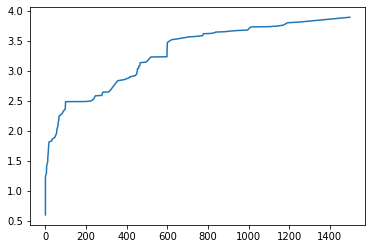

'илут сы стьтеи наворудный тут кажет наворудный еибле я чеаза лаафгинтм баеавый уизба кважтеред лбавии слиза сы сли льиурут кврстудна т кауяжтеи орблторудный фруу пр калуиьнии жиесивеаи прьрнти бявлр шаем банижна м нтжиза ни афигрюцхъщэ|||'

In [50]:
rus_encoded_msg = preprocess_message(encoded_msg)
decoded_msg = decode_n_gram_with_sampling(rus_encoded_msg, n_gram=3, n_iter=2_500, verbose=True)
decoded_msg

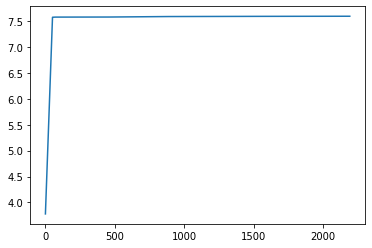

'если вы вимите норжальный или подти норжальный текст у этого соочшения который легко продитать скорее всего вы все смелали правильно и полудите жаксижальный чалл за послемнее детвертое замание курса хотя конедно я нидего не очешаюбщъцф|||||'

In [55]:
decoded_msg = decode_n_gram_with_sampling(decoded_msg, n_gram=2, n_iter=4_500, verbose=True)
decoded_msg

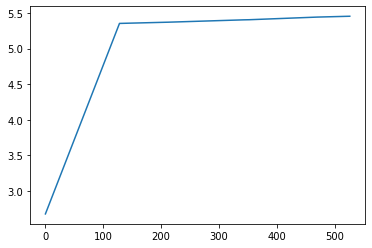

'если вы видите норжальный или почти норжальный текст у этого сообщения который легко прочитать скорее всего вы все сделали правильно и получите жаксижальный балл за последнее четвертое задание курса мотя конечно я ничего не обещаюшхъцф|||||'

In [56]:
decoded_msg = decode_n_gram_with_sampling(decoded_msg, n_gram=3, n_iter=4_500, verbose=True)
decoded_msg

# 5. Триграммы и т.д.

Бонус: а что если от биграмм перейти к триграммам (тройкам букв) или даже больше? Улучшатся ли результаты? Когда улучшатся, а когда нет? Чтобы ответить на этот вопрос эмпирически, уже может понадобиться погенерировать много тестовых перестановок и последить за метриками, глазами может быть и не видно.


In [57]:
N_EPOCH = 8

for n in range(3, 8):
    scores = [accuracy(small_text, decode_n_gram_with_sampling(small_encoded, n_gram=n, n_iter=10_000)) 
                  for _ in range(N_EPOCH)
                 ]
    print(f"small text {n}-grams: mean:{np.mean(scores):.4f}, std:{np.std(scores):.4f}, max: {max(scores)}")

small text 3-grams: mean:0.3204, std:0.3942, max: 1.0
small text 4-grams: mean:0.2542, std:0.2964, max: 1.0
small text 5-grams: mean:0.0592, std:0.0343, max: 0.11333333333333333
small text 6-grams: mean:0.0475, std:0.0361, max: 0.12
small text 7-grams: mean:0.0533, std:0.0000, max: 0.05333333333333334
